In [1]:
import dask.bag as db
import dask
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import numpy as np
import os
import time
import json

/ext3/miniconda3/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [17]:
LOCAL = True

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(
                           # Memory and core limits should be sufficient here
                           memory='4GB', cores=2,

                           # Ensure that Dask uses the correct version of Python on the cluster
                           python='/scratch/work/public/dask/{}/bin/python'.format(dask.__version__),                           
                           
                           # Place the output logs in an accessible location
                           job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(50)

    display(cluster)
    client = Client(cluster)

display(client)

/ext3/miniconda3/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43657 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43657/status,
Dashboard: http://127.0.0.1:43657/status,Workers: 3
Total threads: 9,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37067,Workers: 3
Dashboard: http://127.0.0.1:43657/status,Total threads: 9
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:41043,Total threads: 3
Dashboard: http://127.0.0.1:44133/status,Memory: 2.67 GiB
Nanny: tcp://127.0.0.1:41155,


## Dataset example - Dask

In [39]:
sample_path = os.path.join(os.getcwd(), "data_sample.json")
with open(sample_path, 'r') as file:
    data = json.load(file)

In [42]:
data[0].keys()

dict_keys(['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together'])

In [ ]:
"""
The goal is to get ratings into integer format e.g. 4.5 to 4
"""

In [19]:
path = os.path.join(os.getcwd(), "meta_Toys_and_Games.jsonl")

In [20]:
%%time
b = db.read_text(path).map(json.loads)
bag = b.pluck('average_rating')
bag_as_int = bag.map(lambda x: int(float(x)))
compute_bag_as_int = bag_as_int.compute()

CPU times: user 8.02 s, sys: 1.29 s, total: 9.32 s
Wall time: 38.6 s


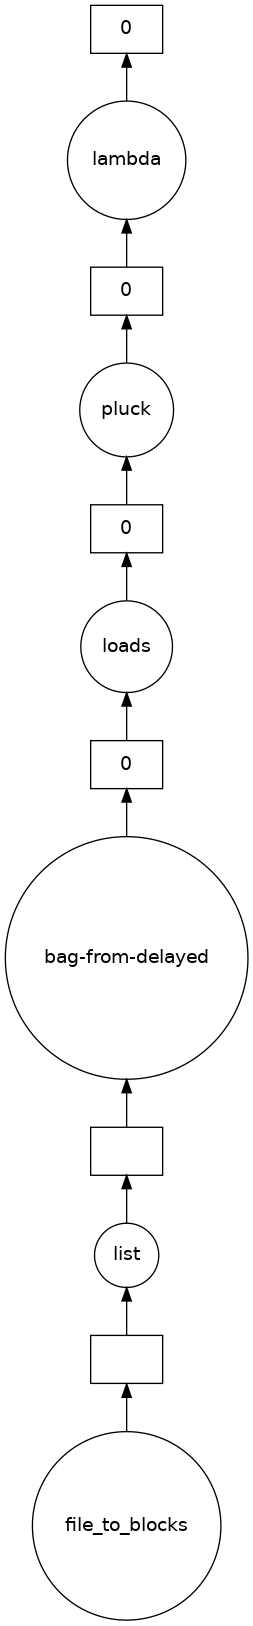

In [21]:
bag_as_int.visualize()

## Dataset example - List

- Kernel dies: If instead we only process one column at a time then list will be faster (17s), but it basically cannot handle loading all the columns

In [ ]:
%%time
with open(path, 'r') as file:
    data = [json.loads(line) for line in file]
    
ratings = [int(float(data['average_rating'])) for line in file]